In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot

## Configuration constants

In [2]:
# patch size
tgt_width = 14
tgt_height = 14

# training batch size
batch_size = 128

## Set up training/validation data with augmentation

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=30,
    width_shift_range=4, height_shift_range=4, brightness_range=[0.8,1.2],
    shear_range=0.0, zoom_range=[0.8,1.2],
    channel_shift_range=20., fill_mode='reflect',
    horizontal_flip=True, vertical_flip=True, rescale=1.0/256.0,
    validation_split=0.2
)

In [4]:
train_gen = train_datagen.flow_from_directory(
        'patchset',
        subset='training',
        target_size=(tgt_width,tgt_height),
        batch_size=batch_size)
n_train=len(train_gen)

Found 3045 images belonging to 3 classes.


c:\tools\python37\lib\site-packages\keras_preprocessing\image\utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [5]:
val_gen = train_datagen.flow_from_directory(
        'patchset',
        subset='validation',
        target_size=(tgt_width,tgt_height),
        batch_size=batch_size)
n_val=len(val_gen)

Found 761 images belonging to 3 classes.


In [6]:
class_names = train_gen.class_indices
print(class_names)

{'ground': 0, 'pavement': 1, 'unknown': 2}


## Training

In [7]:
model = Sequential([
    layers.Input(shape=(tgt_width,tgt_height,3)),
    layers.Conv2D(10, 5, strides=2, padding='valid', activation='relu'),
    layers.Conv2D(3, 3, padding='valid'),
    layers.GlobalAveragePooling2D(),
])
#model = icenet.make_net((img_width,img_height,3),len(class_names))
#model = icenet.make_tutorial(None,(img_width,img_height,3),len(class_names))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 10)          760       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 3)           273       
_________________________________________________________________
global_average_pooling2d (Gl (None, 3)                 0         
Total params: 1,033
Trainable params: 1,033
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalHinge(),
              metrics=['accuracy'])

In [9]:
epochs=15
history = model.fit(
  train_gen, steps_per_epoch=n_train,
  validation_data=val_gen, validation_steps=n_val,
  epochs=epochs
)

Epoch 1/15
24/24 [==============================] - 4s 162ms/step - loss: 1.0612 - accuracy: 0.5293 - val_loss: 0.8935 - val_accuracy: 0.7753
Epoch 2/15
24/24 [==============================] - 3s 139ms/step - loss: 0.8379 - accuracy: 0.7653 - val_loss: 0.6500 - val_accuracy: 0.7819
Epoch 3/15
24/24 [==============================] - 3s 137ms/step - loss: 0.6207 - accuracy: 0.8006 - val_loss: 0.5112 - val_accuracy: 0.8160
Epoch 4/15
24/24 [==============================] - 3s 138ms/step - loss: 0.4865 - accuracy: 0.8339 - val_loss: 0.4828 - val_accuracy: 0.8200
Epoch 5/15
24/24 [==============================] - 3s 137ms/step - loss: 0.4093 - accuracy: 0.8556 - val_loss: 0.4066 - val_accuracy: 0.8476
Epoch 6/15
24/24 [==============================] - 3s 137ms/step - loss: 0.3988 - accuracy: 0.8596 - val_loss: 0.4079 - val_accuracy: 0.8515
Epoch 7/15
24/24 [==============================] - 3s 138ms/step - loss: 0.3805 - accuracy: 0.8700 - val_loss: 0.4032 - val_accuracy: 0.8502
Epoch 

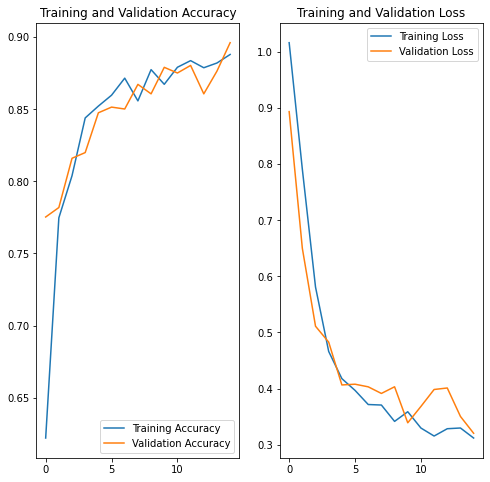

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate performance

In [11]:
val_gen.reset()
Y_pred = []
expected = []
for i in range(n_val):
    imgs, labels = next(val_gen)
    pred = model.predict(imgs)
    Y_pred.extend(pred)
    expected.extend(labels)

In [12]:
y=np.argmax(expected, axis=1)
y_pred = np.argmax(Y_pred, axis=1)
print(tf.math.confusion_matrix(y, y_pred))

tf.Tensor(
[[295   0   5]
 [  2 277  21]
 [ 51  10 100]], shape=(3, 3), dtype=int32)


In [13]:
sum(y == y_pred)/len(y_pred)

0.8830486202365309

## Save model

In [14]:
model.save('patch-classifier')

INFO:tensorflow:Assets written to: patch-classifier\assets
